In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp

In [2]:
def generalized_binom_coef(x,y):
    
#     if type(x) == int and type(y) == np.ndarray:
#         x = np.full_like(y, x)
#     if type(y) == int and type(y) == np.ndarray:
#         y = np.full_like(x, y)

    return sp.special.gamma(x+1) / (sp.special.gamma(y+1) * sp.special.gamma(x-y+1))

class toy_rv(stats.rv_discrete):
    
    def _pmf(self, k, n, p):
        
        return generalized_binom_coef(n, k) * p ** (k) * (1-p)**(n-k)
        

In [3]:
def naive_estimation(observed, p_hat=0.1):
    
    mu_hat = np.log(observed.mean()) - np.log(p_hat) - (1/2)*np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1)
    
    sigma_hat = np.sqrt(np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1))

    return mu_hat, sigma_hat

In [113]:
def generate_moment_mat(size=2):
    
    B = np.zeros((size, 2))
    B[:, 0] = np.arange(size)+1
    B[:, 1] = (np.arange(size)+1)**2/2
    return B

def get_observed_moments(data, order=2):
    
    return np.array([(data**(i+1)).mean() for i in range(order)]).reshape(-1, 1)

def linsys_estimation(data, p=0.1, order=2, lam_max=3):
    
    if order == 3:
        A = np.zeros((3,3))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        A[2, 0] = (2*p**3 - 3*p**2 + p)
        A[2, 1] = (3*p**2 - 3*p**3)
        A[2, 2] = p**3
    else:
        A = np.zeros((2,2))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        
    lam = 0.2/((data < 1).mean())
    
    logex = np.log(np.linalg.inv(A).dot(get_observed_moments(data, order=order)))
    B = generate_moment_mat(size=order)
    R = lam * np.array([1, -1]).reshape(1, -1)
    sol = np.linalg.inv(B.T.dot(B) + R.T.dot(R)).dot(B.T).dot(logex)
    #sol = np.linalg.inv(B.T.dot(B)).dot(B.T.dot(logex) - R)
    return logex, sol[0, 0], np.sqrt(sol[1, 0])

In [122]:
mu = -3
sigma = 1

In [123]:
mean_list = []
var_list = []

for trial in range(20):

    lognorm_data = stats.lognorm.rvs(
        s=sigma, 
        scale=np.exp(mu), 
        size=2000)
    # norm_data = stats.norm.rvs(
    #     loc=mu, 
    #     scale=sigma, 
    #     size=1000)
    data = \
        toy_rv().rvs(
            n=lognorm_data,
            p=0.1)
    
    logex, m, v = linsys_estimation(data, order=3)
    
    mean_list.append(m)
    var_list.append(v)

In [125]:
stats.pearsonr(mean_list, var_list)

(-0.9994772359125319, 2.7636261197940524e-28)

In [126]:
logex

array([[-2.46510402],
       [-2.46510402],
       [-2.46510402]])

In [127]:
np.log(get_observed_moments(lognorm_data, order=3))

array([[-2.53959438],
       [-4.08222804],
       [-4.59734322]])

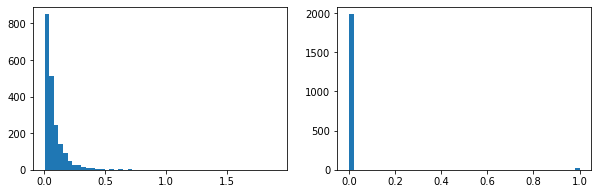

In [128]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
plt.hist(lognorm_data, bins=50);
plt.subplot(1, 2, 2);
plt.hist(data, bins=50);

In [384]:
logex = np.log(np.linalg.inv(A).dot(get_observed_moments(data, order=3)))

In [385]:
logex

array([[1.37371558],
       [3.5931942 ],
       [1.51583028]])

In [386]:
np.log(get_observed_moments(lognorm_data, order=3))

array([[1.46499602],
       [3.8641409 ],
       [6.92191514]])

In [9]:
def generate_moment_mat(size=2):
    
    B = np.zeros((size, 2))
    B[:, 0] = np.arange(size)+1
    B[:, 1] = (np.arange(size)+1)**2/2
    return B

def get_observed_moments(data, order=2):
    
    return np.array([(data**(i+1)).mean() for i in range(order)]).reshape(-1, 1)

def linsys_estimation(data, p=0.1, order=2, lam=0.1):
    
    if order == 3:
        A = np.zeros((3,3))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        A[2, 0] = (2*p**3 - 3*p**2 + p)
        A[2, 1] = (3*p**2 - 3*p**3)
        A[2, 2] = p**3
    else:
        A = np.zeros((2,2))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2    
    
    logex = np.log(np.linalg.inv(A).dot(get_observed_moments(data, order=order)))
    B = generate_moment_mat(size=order)
    R = lam * np.array([1, -1]).reshape(1, -1)
    #sol = np.linalg.inv(B.T.dot(B) + R.T.dot(R)).dot(B.T).dot(logex)
    sol = np.linalg.inv(B.T.dot(B)).dot(B.T.dot(logex) - R)
    return np.exp(logex), sol[0, 0], np.sqrt(sol[1, 0])

In [536]:
linsys_estimation(data, order=3)

(-5.124135468723669, 1.5635940693408688)

In [133]:
n = 5
p = 0.1

In [157]:
stats.binom.expect(lambda x: x**3, args=(n,p))

1.1599999999999997

In [158]:
n**2*(p**2) - n*p*(p-1)

0.7000000000000001

In [161]:
n**3*p**3 + n**2*(3*p**2 - 3*p**3) + n*(2*p**3 - 3*p**2 + p)

1.1600000000000001